In [196]:
import pandas as pd
import datetime
import math
import numpy as np

class CoordinateConverter:
    def __init__(self, filename):
        """
        Initialize a CoordinateConverter object with the given filename and a fixed epoch date.
        
        :param filename: The name of the CSV file containing data to be processed.
        """
        self.df = pd.read_csv(filename)
        self.epoch = datetime.datetime(2000, 1, 1)
        self.grbs_error = []
        self.result_df = self.process_data()


    def convert_to_xyz(self, longitude, latitude, altitude):
        """
        Convert longitude, latitude, and altitude to Cartesian coordinates (x, y, z).
        
        :param longitude: The longitude in degrees.
        :param latitude: The latitude in degrees.
        :param altitude: The altitude in meters.
        :return: Tuple of Cartesian coordinates (x, y, z).
        """
        longitude_rad = math.radians(longitude)
        latitude_rad = math.radians(latitude)
        
        x = math.cos(latitude_rad) * math.cos(longitude_rad)
        y = math.cos(latitude_rad) * math.sin(longitude_rad)
        z = math.sin(latitude_rad)
        
        return x, y, z
    
    
    def days_since_epoch_to_datetime(self,days_since_epoch):
        # Calculate the total seconds since the epoch
        total_seconds = days_since_epoch * 24 * 60 * 60

        # Create a datetime object by adding the total seconds to the epoch
        result_datetime = self.epoch + datetime.timedelta(seconds=total_seconds)

        return result_datetime
    
    
    def process_data(self):
        """
        Read, process, and transform data from the CSV file.
        
        :return: A DataFrame containing processed data with added Cartesian coordinates.
        """
        print("Proccesing data")
        
        # Filter rows where exposure(s) is 1
        filtered_df = self.df[self.df["exposure(s)"].fillna(0) == 1]
        
        # Drop unnecessary columns
        filtered_df = filtered_df.drop(columns=["sat", "exposure(s)"])
        
        # Convert "direction" column to binary (1 for "north-to-south", 0 for others)
        filtered_df["direction"] = filtered_df["direction"].apply(lambda x: 1 if x == "north-to-south" else 0)
        
        # Convert "time" column to days since epoch
        filtered_df["datetime"] = pd.to_datetime(filtered_df["time"])
        filtered_df["datetime"] = (filtered_df["datetime"] - self.epoch).dt.days + (filtered_df["datetime"] - self.epoch).dt.seconds / (24 * 60 * 60)
        self.first_light = min(filtered_df["datetime"])
        filtered_df["datetime"] = filtered_df["datetime"] - min(filtered_df["datetime"])
        
        # Convert longitude, latitude, and altitude to Cartesian coordinates
        xyz_coordinates = filtered_df.apply(lambda row: self.convert_to_xyz(row["longitude"], row["latitude"], row["altitude"]), axis=1)
        xyz_df = pd.DataFrame(xyz_coordinates.tolist(), columns=["x", "y", "z"], index=xyz_coordinates.index)
        
        # Concatenate Cartesian coordinates with the filtered DataFrame
        self.result_df = pd.concat([filtered_df, xyz_df], axis=1)
        
        return self.result_df
    
    
    
    def data_split_GONG(self, file_list_of_GRB_peak_time):
        print('Data splitting')
        grbs = []
        df = self.result_df
        grb_time = pd.read_csv(file_list_of_GRB_peak_time, header=None)
        list_of_GRB_peak_time = pd.to_datetime(grb_time[0].str.strip('""'))
        list_of_GRB_peak_time = ((list_of_GRB_peak_time - self.epoch).dt.days + (list_of_GRB_peak_time - self.epoch).dt.seconds / (24 * 60 * 60)) - self.first_light
        for value in list(list_of_GRB_peak_time):
            self.grbs_error.append(abs(value - df["datetime"]))
            if min(list(abs(value - df["datetime"]))) < 0.1:
                i = np.argmin(abs(value - df["datetime"]))
                start = max(0, i - (128 + 128))
                end = min(len(df["datetime"]), i + 128)
                grbs.append(df.iloc[start:end].to_numpy())
                df.drop(df.index[start:end], inplace=True)
        return grbs, df

In [197]:
filename = 'all_cubesat_data_newest.csv'
file_list_of_GRB_peak_time = "grb_time.csv"

In [198]:
converter = CoordinateConverter(filename)

Proccesing data


In [120]:
converter.first_light

7775.9291087962965

In [121]:
%time grbs, remaining_data = converter.data_split_GONG(file_list_of_GRB_peak_time)

Data splitting
CPU times: user 11.3 s, sys: 1.39 s, total: 12.7 s
Wall time: 11.3 s


In [126]:
import matplotlib.pyplot as plt

In [200]:
grbs[0][256][0]

'2021-10-19 06:01:36.500'

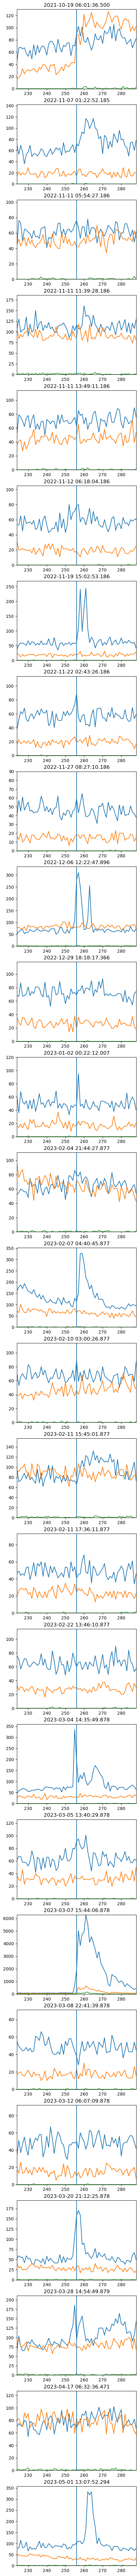

In [201]:
fig, ax = plt.subplots(len(grbs),figsize=(5,4*len(grbs)))
for i in range(len(grbs)):
    ax[i].plot(grbs[i].T[-7])
    ax[i].plot(grbs[i].T[-6])
    ax[i].plot(grbs[i].T[-5])
    ax[i].set_xlim(256-32,256+32)
    ax[i].set_ylim(0,25+max(grbs[i].T[-7][256-32:256+32]))
    ax[i].vlines(256, 0,100+max(grbs[i].T[-7][256-32:256+32]))
    ax[i].set_title((grbs[i][256][0]))